# Concurrency on CPython: GIL, Pools, and Parallelism

---

## Global Interpreter Lock

The Global Interpreter Lock (GIL) is a process-wide mutex in CPython that ensures only one thread executes Python bytecode at any given time, even on multi-core CPUs. It mainly exists to make CPython’s memory management simpler and safe: reference counting updates are not individually atomic, so without a global lock, multiple threads could corrupt object state or crash the interpreter when adjusting reference counts concurrently. By serializing bytecode execution, the GIL prevents these race conditions at the cost of limiting true parallelism for CPU-bound Python code; I/O-bound programs can still benefit from threading because threads often release the GIL while waiting on system calls.

Starting with Python 3.13 - 3.14, an experimental free-threaded (no-GIL) build of CPython is being developed, which removes the GIL and replaces it with more fine-grained synchronization and atomic operations; this variant is a good target to benchmark Python without the traditional GIL constraints.

In [1]:
import logging
import os
import sysconfig
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from urllib.request import urlopen

import matplotlib.pyplot as plt

In [2]:
log = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

In [3]:
gil_disabled = sysconfig.get_config_var("Py_GIL_DISABLED")
log.info(f"Python GIL disabled: {gil_disabled == 1}")

2026-01-22 22:47:02,252 [INFO] Python GIL disabled: False


In [4]:
log.info(f"CPU count: {os.cpu_count()}")

2026-01-22 22:47:02,264 [INFO] CPU count: 16


## Thread & Process Pools

Thread and process pools are the two main mechanisms for running work in parallel in Python, but they behave very differently because of the GIL and the way the OS manages memory and processes. A good mental model is: threads share everything inside one Python interpreter, while processes each run their own interpreter in separate address spaces, which changes both performance characteristics and failure modes.

Multithreading shines when tasks are I/O‑bound: code that spends most of its time waiting on the network, disk, or other external resources. In that case, while one thread is blocked in an I/O system call (and usually releases the GIL), another thread can make progress, so you get real throughput improvements even though only one thread runs Python bytecode at a time. Threads are also attractive when you want to share in‑memory state cheaply, such as caches, connection pools, or large read‑only datasets, because all threads see the same objects without copying.

Multiprocessing is the tool of choice for CPU‑bound workloads, where the bottleneck is pure Python execution rather than waiting on the outside world. Each worker process has its own GIL and interpreter, so $N$ processes can truly run in parallel on $N$ cores, which is not possible with pure threads in CPython for CPU-heavy code. The trade‑off is higher overhead: each process has its own memory footlog.info, must be started by the OS, and communicates via pipes, queues, or shared memory rather than ordinary Python references.

## Example: CPU Work

We measure how different executors scale on a fixed CPU-bound workload: computing the sum of squares from 0 to N for various numbers of workers. Take a pure CPU-bound function that computes:
$$
\sum_{i = n}^{m - 1} i^2
$$

- Helper functions (all compute the same total work, the sum of squares from 0 to $N$):

  - `time_sequential_sum(N)`: computes `sum_squares_range(0, N)` in a single thread.
  - `time_threaded_sum(N, k)`: splits the range $[0, N)$ into k disjoint chunks, runs them in a `ThreadPoolExecutor(max_workers=k)`, and adds the partial results.
  - `time_process_sum(N, k)`: uses the same partitioning, but runs the chunks in a `ProcessPoolExecutor(max_workers=k)`.

The total  work is equivalent in all cases: sum of squares up to $N$.

In [5]:
def sum_squares_range(start: int, stop: int) -> int:
    total = 0
    for i in range(start, stop):
        total += i * i
    return total


def partition_range(N: int, chunks: int):
    """Yield (start, stop) pairs that cover range(N) in 'chunks' slices."""
    base = N // chunks
    rem = N % chunks
    start = 0
    for i in range(chunks):
        # First 'rem' chunks get one extra element
        size = base + (1 if i < rem else 0)
        stop = start + size
        yield start, stop
        start = stop


def time_sequential_sum(N: int) -> float:
    start_t = time.perf_counter()
    _ = sum_squares_range(0, N)
    return time.perf_counter() - start_t


def time_threaded_sum(N: int, workers: int) -> float:
    ranges = list(partition_range(N, workers))
    start_t = time.perf_counter()
    with ThreadPoolExecutor(max_workers=workers) as ex:
        futures = [ex.submit(sum_squares_range, a, b) for (a, b) in ranges]
        _ = sum(f.result() for f in as_completed(futures))
    return time.perf_counter() - start_t


def time_process_sum(N: int, workers: int) -> float:
    ranges = list(partition_range(N, workers))
    start_t = time.perf_counter()
    with ProcessPoolExecutor(max_workers=workers) as ex:
        futures = [ex.submit(sum_squares_range, a, b) for (a, b) in ranges]
        _ = sum(f.result() for f in as_completed(futures))
    return time.perf_counter() - start_t

2026-01-22 22:47:05,967 [INFO] === workers = 1 ===
2026-01-22 22:47:13,980 [INFO] === workers = 2 ===
2026-01-22 22:47:20,808 [INFO] === workers = 4 ===
2026-01-22 22:47:26,854 [INFO] === workers = 8 ===
2026-01-22 22:47:31,748 [INFO] === workers = 16 ===
2026-01-22 22:47:37,097 [INFO] === workers = 32 ===
2026-01-22 22:47:42,837 [INFO] === workers = 64 ===


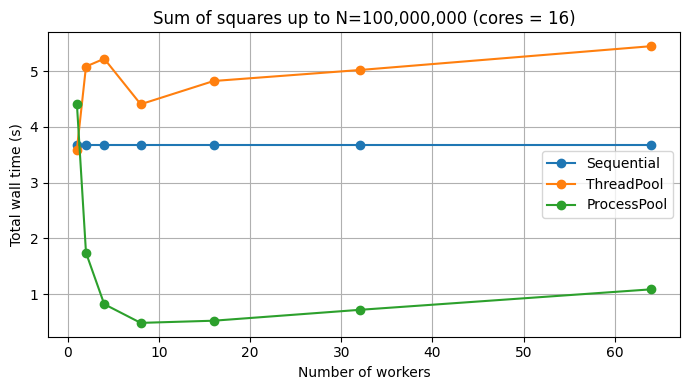

In [6]:
N = 100_000_000
cores = os.cpu_count()

worker_counts = [1, 2, 4, 8, cores, 2 * cores, 4 * cores]


thr_times = []
proc_times = []
sec_times = [time_sequential_sum(N)] * len(worker_counts)

for k in worker_counts:
    log.info(f"=== workers = {k} ===")
    t_thr = time_threaded_sum(N, k)
    t_proc = time_process_sum(N, k)
    thr_times.append(t_thr)
    proc_times.append(t_proc)

plt.figure(figsize=(7, 4))
plt.plot(worker_counts, sec_times, "o-", label="Sequential")
plt.plot(worker_counts, thr_times, "o-", label="ThreadPool")
plt.plot(worker_counts, proc_times, "o-", label="ProcessPool")
plt.xlabel("Number of workers")
plt.ylabel("Total wall time (s)")
plt.title(f"Sum of squares up to N={N:,} (cores = {cores})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For CPU‑bound workloads, a process pool usually speeds up as you increase workers up to roughly the number of physical cores, because each process runs in its own interpreter with its own GIL and can saturate a separate core in true parallelism. Once the number of processes exceeds the core count, the OS must time‑slice them on the same cores, which increases context switches and cache misses and often flattens or worsens performance. In contrast, a thread pool stays constrained by the single GIL from the beginning for pure Python CPU‑bound code, so only one thread executes Python bytecode at a time and added threads mostly add lock and scheduling overhead, keeping total runtime near or worse than the sequential baseline

## Example: I/O Task

This experiment measures how different executors behave on a fixed I/O-bound workload: running the same number of fake I/O tasks for various numbers of workers. We call sleep which simulates an I/O-bound operation that mostly waits (e.g. network or disk) and does essentially no CPU work.

Helper functions:

- `time_sequential_io(tasks, delay)`: runs `fake_io_task(delay)` `tasks` times in a simple for-loop, one after another.
- `time_threaded_io(tasks, workers, delay)`: submits `tasks` calls to `fake_io_task(delay)` into a `ThreadPoolExecutor(max_workers=workers)` and waits for all futures to complete.
- `time_process_io(tasks, workers, delay)`: same, but uses a `ProcessPoolExecutor(max_workers=workers)`.

The total amount of “real work” is constant: `tasks` calls to `fake_io_task(delay)`, so `tasks * delay` seconds of sleeping when done strictly sequentially.

In [7]:
def fake_io_task(delay: float = 0.3) -> int:
    """Simulate I/O-bound work: mostly sleeping, tiny CPU tail."""
    time.sleep(delay)  # pretend network / disk wait
    return 0


def time_sequential_io(tasks: int, delay: float) -> float:
    start = time.perf_counter()
    for _ in range(tasks):
        fake_io_task(delay)
    return time.perf_counter() - start


def time_threaded_io(tasks: int, workers: int, delay: float) -> float:
    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=workers) as ex:
        futures = [ex.submit(fake_io_task, delay) for _ in range(tasks)]
        for _ in as_completed(futures):
            pass
    return time.perf_counter() - start


def time_process_io(tasks: int, workers: int, delay: float) -> float:
    start = time.perf_counter()
    with ProcessPoolExecutor(max_workers=workers) as ex:
        futures = [ex.submit(fake_io_task, delay) for _ in range(tasks)]
        for _ in as_completed(futures):
            pass
    return time.perf_counter() - start

2026-01-22 22:47:50,105 [INFO] === workers = 1 ===
2026-01-22 22:47:51,198 [INFO] === workers = 2 ===
2026-01-22 22:47:51,774 [INFO] === workers = 4 ===
2026-01-22 22:47:52,115 [INFO] === workers = 8 ===
2026-01-22 22:47:52,354 [INFO] === workers = 16 ===
2026-01-22 22:47:52,642 [INFO] === workers = 32 ===
2026-01-22 22:47:53,056 [INFO] === workers = 64 ===


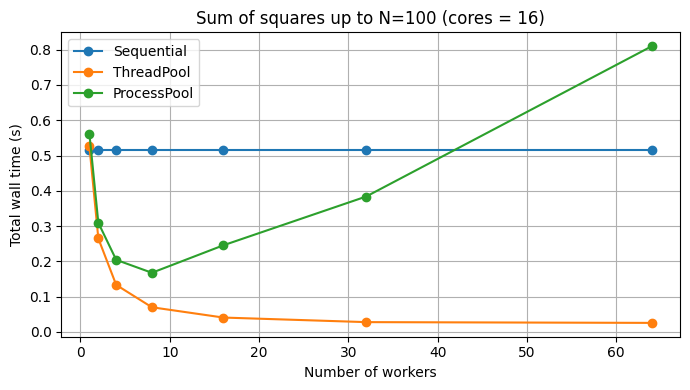

In [8]:
N = 100

worker_counts = [1, 2, 4, 8, cores, 2 * cores, 4 * cores]


thr_times = []
proc_times = []
sec_times = [time_sequential_io(N, 0.005)] * len(worker_counts)

for k in worker_counts:
    log.info(f"=== workers = {k} ===")
    t_thr = time_threaded_io(N, k, 0.005)
    t_proc = time_process_io(N, k, 0.005)
    thr_times.append(t_thr)
    proc_times.append(t_proc)

plt.figure(figsize=(7, 4))
plt.plot(worker_counts, sec_times, "o-", label="Sequential")
plt.plot(worker_counts, thr_times, "o-", label="ThreadPool")
plt.plot(worker_counts, proc_times, "o-", label="ProcessPool")
plt.xlabel("Number of workers")
plt.ylabel("Total wall time (s)")
plt.title(f"Sum of squares up to N={N:,} (cores = {cores})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This I/O‑bound experiment shows that threads are effective while processes are overkill. All variants perform the same work: a fixed number of fake_io_task(delay) calls that just sleep, so the true cost is waiting, not CPU. Sequential execution takes about tasks * delay seconds because each sleep runs one after another. A thread pool can overlap these sleeps within a single process, so as you increase the number of threads, total wall time drops well below the sequential baseline, up to the point where all tasks can be in flight at once and additional threads only add overhead. In contrast, a process pool must pickle arguments and results, send them over inter‑process channels, and schedule separate Python interpreters, which is expensive relative to a 5 ms sleep. Because there is almost no CPU work to amortize that overhead, the process‑pool curve typically stays near or above the sequential time, illustrating that process pools are a poor fit for small, I/O‑bound tasks and are best reserved for heavier CPU‑bound workloads instead.

## Hybrid Approach

The experiment runs the same mixed I/O + CPU job in three different ways and compares their wall‑clock times.

Each job does two steps:

- I/O phase: for each URL in a small list `URLS`, call a blocking `fetch(url)` and collect all response bodies.
- CPU phase: pass the list of bodies to `heavy_compute(bodies)`, a CPU‑bound function that loops over the bytes and does some arithmetic work.

You choose a number of jobs `num_jobs` (for example 4 or 8), and then measure how long it takes to run those `num_jobs` under three execution strategies:

1. Sequential version

   - Loop from 1 to `num_jobs`.
   - For each job, call `fetch` for all URLs one after another, then call `heavy_compute` once.
   - Everything runs in a single thread and a single process.
   - Measure the total wall time.

2. Threads‑only version

   - Create a `ThreadPoolExecutor(max_workers=num_jobs)`.
   - For each job, submit a function that does “fetch all URLs sequentially, then run heavy_compute”.
   - Wait for all thread futures to complete and record the total wall time.
   - I/O phases from different jobs can overlap across threads, but all CPU work still happens in one Python process with one GIL.

3. Hybrid (processes + threads) version

   - Create a `ProcessPoolExecutor(max_workers=cores)`, where `cores` is the number of CPU cores.
   - For each job, submit `process_job(job_id, URLS)` to the process pool.
   - Inside `process_job` (running in a worker process):
     - Create a small `ThreadPoolExecutor(max_workers=len(URLS))`.
     - Submit one `fetch(url)` per URL to that thread pool and wait for all results, so the I/O for that job is overlapped using threads.
     - After all bodies are fetched, call `heavy_compute(bodies)` once in that process.
   - Wait for all process futures to finish and measure the total wall time.



In [ ]:
URLS = [
    "https://httpbin.org/delay/1",
    "https://httpbin.org/bytes/200000",
    "https://httpbin.org/bytes/300000",
]


def fetch(url: str) -> bytes:
    """I/O-bound: HTTP GET."""
    with urlopen(url, timeout=10) as resp:  # noqa: S310
        return resp.read()


def heavy_compute(data_list: list[bytes]) -> int:
    """CPU-bound: dummy heavy transform on concatenated bytes."""
    total = 0
    for data in data_list:
        for b in data:
            total = (total * 131 + b) & 0xFFFFFFFF
    return total


# -------- hybrid worker: threads for I/O, then CPU --------


def process_job(job_id: int, urls: list[str]) -> int:
    # 1) I/O fan-out via threads inside this process
    with ThreadPoolExecutor(max_workers=len(urls)) as pool:
        futures = [pool.submit(fetch, u) for u in urls]
        bodies = [f.result() for f in as_completed(futures)]

    # 2) CPU-bound work on the fetched data (per-process GIL)
    return heavy_compute(bodies)


# -------- orchestrator: processes for CPU parallelism --------


def run_hybrid(num_jobs: int) -> float:
    start = time.perf_counter()
    with ProcessPoolExecutor(max_workers=os.cpu_count() or 4) as pool:
        futures = [pool.submit(process_job, j, URLS) for j in range(num_jobs)]
        results = [f.result() for f in as_completed(futures)]
    elapsed = time.perf_counter() - start
    log.info(
        f"Hybrid: {num_jobs} jobs -> {elapsed:.3f}s, sample={results[0] if results else None}"
    )
    return elapsed


# -------- baselines for comparison --------


def run_sequential(num_jobs: int) -> float:
    start = time.perf_counter()
    for _ in range(num_jobs):
        bodies = [fetch(u) for u in URLS]  # serial I/O
        _ = heavy_compute(bodies)  # serial CPU
    elapsed = time.perf_counter() - start
    log.info(f"Sequential: {num_jobs} jobs -> {elapsed:.3f}s")
    return elapsed


def run_threads_only(num_jobs: int) -> float:
    """Threads overlap I/O but CPU stays GIL-bound."""

    def job(_):
        bodies = [fetch(u) for u in URLS]
        return heavy_compute(bodies)

    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=num_jobs) as pool:
        futures = [pool.submit(job, j) for j in range(num_jobs)]
        _ = [f.result() for f in as_completed(futures)]
    elapsed = time.perf_counter() - start
    log.info(f"Threads only: {num_jobs} jobs -> {elapsed:.3f}s")
    return elapsed


if __name__ == "__main__":
    jobs = 4
    run_sequential(jobs)
    run_threads_only(jobs)
    run_hybrid(jobs)

2026-01-22 22:48:07,842 [INFO] Sequential: 4 jobs -> 13.810s
2026-01-22 22:48:11,642 [INFO] Threads only: 4 jobs -> 3.798s
2026-01-22 22:48:14,050 [INFO] Hybrid: 4 jobs -> 2.406s, sample=2314104103


The hybrid experiment demonstrates where combining processes and threads actually pays off: when each job has a meaningful I/O phase and a meaningful CPU phase, you can let threads overlap the I/O waits and let processes run the CPU work in parallel on multiple cores. In this setup, sequential is slowest because neither I/O nor CPU is parallelized, the threads‑only version gains from overlapping network waits but cannot fully exploit multiple cores, and the hybrid version can beat both when heavy_compute is expensive enough, because it achieves concurrency for I/O inside each process and true multi‑core parallelism for CPU across processes.